<a href="https://colab.research.google.com/github/ytg000629/ai4dl/blob/main/project/bertweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 설치,import, 데이터 준비



In [1]:
!pip install keras_preprocessing
!pip install emoji
!pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.8/355.8 kB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.0-py2.py3-none-any.whl size=351211 sha256=c5c70b5bb8f233cf7a6636ae8d3a28030c8cc75077f3b619e14e23667823f6ab
  Stored in directory: /root/.cache/pip/wheels/2a/0c/2c/07b5af72b120503fe24590691d24c462a25e5e530db8700a96
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 32.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha25

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import emoji

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import  Counter
plt.style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
import wordcloud
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences #keras_preprocessing

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, SimpleRNN, Bidirectional
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings(action  = 'ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from autocorrect import Speller

In [4]:
#%config Completer.use_jedi = False

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_train = pd.read_csv('drive/MyDrive/nlp-getting-started/train.csv')
df_test = pd.read_csv('drive/MyDrive//nlp-getting-started/test.csv')
df_sample = pd.read_csv('drive/MyDrive//nlp-getting-started/sample_submission.csv')

In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df_train.shape

(7613, 5)

In [9]:
df_test.shape

(3263, 4)

In [10]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 데이터 전처리

In [11]:
#불용어 사전 정의
stop=set(stopwords.words('english'))

#spell check 진행 정도 파악을 위
tqdm.pandas()

def text_preproccessing(df):

    df = df.copy()

    # URL 제거
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    # HTML tag 제거
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    # 구두점 제거
    def remove_punct(text):
        table=str.maketrans('','',string.punctuation)
        return text.translate(table)

    # 이모티콘 제거
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    # 불용어 제거
    def remove_stopwords(x):
        return ' '.join([i for i in x.split() if i not in stop])


    # 스펠링 교정
    def spell_check(x):
        spell = Speller(lang='en')
        return " ".join([spell(i) for i in x.split()])


    df['text']=df['text'].apply(lambda x : remove_URL(x))
    df['text']=df['text'].apply(lambda x : remove_html(x))
    df['text']=df['text'].apply(lambda x : remove_punct(x))
    df['text']=df['text'].apply(lambda x : remove_emoji(x))
    df['text']=df['text'].apply(lambda x : remove_stopwords(x))
    #df['text']=df['text'].progress_apply(lambda x : spell_check(x))


    return df

In [12]:
df_train = text_preproccessing(df_train)
df_test = text_preproccessing(df_test)

#50분 정도 소요

In [13]:
df_train.shape

(7613, 5)

In [14]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds Reason earthquake May ALLAH Forgive us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked shelter place notified off...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1


In [15]:
df_test.shape

(3263, 4)

In [16]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened terrible car crash
1,2,NaN,NaN,Heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 China Taiwan


In [17]:
df=pd.concat([df_train,df_test])
df.shape

(10876, 5)

# BERTweet

In [18]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.0 MB/s eta 0:00:00


In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [20]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [21]:
train_data, val_data, train_labels, val_labels = train_test_split(df['text'][:df_train.shape[0]].values, df_train['target'].values, test_size=0.2, stratify=df_train['target'].values, random_state=0)

In [42]:
train_data.shape

(6090,)

In [44]:
val_data.shape

(1523,)

In [45]:
df['text'][df_train.shape[0]:].values.shape

(3263,)

In [46]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base',
                                          normalization=True,
                                          use_fast = False,
                                          add_special_tokens=True,
                                          pad_to_max_length=True,
                                          return_attention_mask=True)

train_token = tokenizer(train_data.tolist(),
                    padding="max_length",
                    truncation=True,
                    return_tensors = 'tf').data
val_token = tokenizer(val_data.tolist(),
                    padding="max_length",
                    truncation=True,
                    return_tensors = 'tf').data
test_token = tokenizer(df['text'][df_train.shape[0]:].values.tolist(),
                    padding="max_length",
                    truncation=True,
                    return_tensors = 'tf').data

train_features = {x: train_token[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_tf_dataset = train_tf_dataset.shuffle(len(train_data)).batch(32).prefetch(tf.data.AUTOTUNE)

val_features = {x: val_token[x] for x in tokenizer.model_input_names}
val_tf_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels))
val_tf_dataset = val_tf_dataset.shuffle(len(val_data)).batch(32).prefetch(tf.data.AUTOTUNE)

test_features = {x: test_token[x] for x in tokenizer.model_input_names}
test_tf_dataset = tf.data.Dataset.from_tensor_slices((test_features))
test_tf_dataset = test_tf_dataset.shuffle(len(df['text'][df_train.shape[0]:].values)).batch(32).prefetch(tf.data.AUTOTUNE)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [23]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 32.7 MB/s eta 0:00:00


In [24]:
from transformers import TFRobertaModel
import transformers
import tensorflow_addons as tfa

with strategy.scope():
    bert_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

def build_model(hidden_n, drop = 0.3, lr = 1e-5, weight_decay = 1e-6):
    with strategy.scope():
        input_ids = tf.keras.Input(shape=(128,),dtype='int32', name = 'input_ids')
        attention_masks = tf.keras.Input(shape=(128,),dtype='int32', name = 'attention_mask')

        output = bert_model([input_ids,attention_masks])[1]
        output = tf.keras.layers.Dense(hidden_n,activation='relu')(output)
        output = tf.keras.layers.Dropout(drop)(output)
        output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

        model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

        model.compile(tfa.optimizers.AdamW(weight_decay = weight_decay, lr=lr),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        # Prevent training the transformer from training again
        model.layers[2].trainable = False

        return model

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [25]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )]

In [26]:
model = build_model(32)   # hidden_layer : 32
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [27]:
history = model.fit(train_tf_dataset,
                    validation_data = val_tf_dataset,
                    epochs = 30,
                    batch_size=32,
                    callbacks = callbacks_list)

Epoch 1/30
191/191 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.7760
Epoch 1: val_accuracy improved from -inf to 0.82994, saving model to checkpoint_path.keras
191/191 [==============================] - 239s 999ms/step - loss: 0.5062 - accuracy: 0.7760 - val_loss: 0.4075 - val_accuracy: 0.8299
Epoch 2/30
191/191 [==============================] - ETA: 0s - loss: 0.3922 - accuracy: 0.8437
Epoch 2: val_accuracy improved from 0.82994 to 0.83191, saving model to checkpoint_path.keras
191/191 [==============================] - 189s 988ms/step - loss: 0.3922 - accuracy: 0.8437 - val_loss: 0.3955 - val_accuracy: 0.8319
Epoch 3/30
191/191 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.8680
Epoch 3: val_accuracy did not improve from 0.83191
191/191 [==============================] - 171s 897ms/step - loss: 0.3460 - accuracy: 0.8680 - val_loss: 0.4782 - val_accuracy: 0.8037
Epoch 4/30
191/191 [==============================] - ETA: 0s - loss: 0

In [35]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras',custom_objects={"TFRobertaModel": transformers.TFRobertaModel})

In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

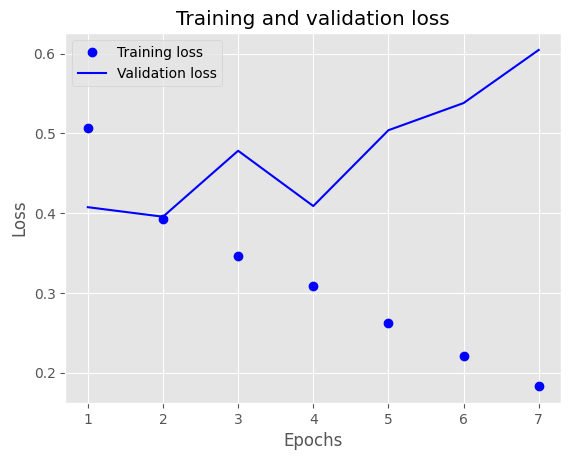

In [37]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

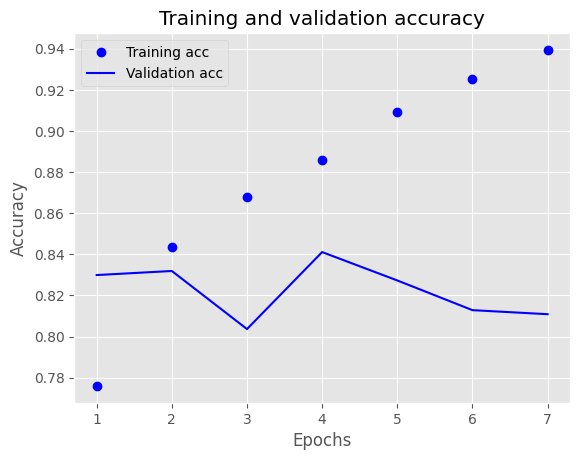

In [38]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [59]:
token = tokenizer(df['text'][df_train.shape[0]:].values.tolist(),
                  padding="max_length",
                  truncation=True,
                  return_tensors = 'tf').data

predict = loaded_model.predict(token)
df_sample['target'] = (predict > 0.5).astype(int)

102/102 [==============================] - 29s 282ms/step


In [60]:
df_sample.to_csv('bertweet.csv',index = False)